In [1]:
import json
import pandas as pd
import matplotlib
import os
import numpy as np

In [43]:
def accelerate_log_to_json(logs, epochs: int, world_size: int, exp_time: float):
    df = pd.DataFrame(logs)
    result = []
    for epoch_i in range(0,epochs):
        dict = {}
        dict["experiment_key"] = f"rank_{world_size}"
        for col in df.columns:
            if col == 'epoch':
                dict[col] = epoch_i
            elif col == 'checkpointing':
                dict[col] = df.loc[df['epoch'] == epoch_i, col].max()
            elif col != 'rank':
                dict[col] = df.loc[df['epoch'] == epoch_i, col].mean()
        dict["epoch_time"] = dict['training_time'] + dict['eval_time'] + dict['checkpointing']
        dict["total_experiment_time"] = exp_time
        result.append(dict)
    return result

def read_accelerate_logs(fileName):
    log = []
    total_exp_time_vals = []
    log_path = os.path.join(os.path.abspath(''), "logs")
    with open(os.path.join(log_path, fileName), 'r') as f:
        for line in f:
            record = json.loads(line)
            if len(record) > 1:
                log.append(record)
            else:
                total_exp_time_vals.append(record["total_experiment_time"])
    exp_time = np.max(total_exp_time_vals)
    return log, exp_time

def create_accelerate_aggregated_df(world_size: int):
        exp_df = []
        for rank in range(1, world_size + 1):
                if rank == 1:
                        rank_record = read_logs("rank_1.json")
                        rank_record[0]["eval_aggregate_and_calc"] = 0.0
                else:
                        log, exp_time = read_accelerate_logs(f"rank_acc_{rank}.log")
                        rank_record = accelerate_log_to_json(logs=log, epochs=1, world_size=rank, exp_time=exp_time)
                exp_df.append(rank_record[0])
        return pd.DataFrame(exp_df)

def read_logs(fileName:str):
        log_path = os.path.join(os.path.abspath(''), "logs")
        with open(os.path.join(log_path, fileName), "r") as outfile:
                return json.load(outfile)

def create_aggregated_df(world_size: int):
        exp_df = []
        for rank in range(1, world_size + 1):
                if rank == 1:
                        rank_record = read_logs("rank_1.json")
                else:
                        rank_record = read_logs(f"rank_ddp_{rank}.json")
                exp_df.append(rank_record[0])
        return pd.DataFrame(exp_df)

In [44]:
exp_acc_logs = create_accelerate_aggregated_df(world_size=8)
exp_acc_df = pd.DataFrame(exp_acc_logs)
exp_acc_df = exp_acc_df.drop("epoch", axis=1)
exp_acc_df

,experiment_key,training_loss,training_time,train_forward_pass,train_backward_pass,train_optimizer_step,train_post_processing,checkpointing,eval_validation_split_loss,eval_validation_split_perplexity,eval_time,eval_post_processing,eval_forward_pass,epoch_time,total_experiment_time,eval_aggregate_and_calc
0,rank_1,3.168389,862.808604,221.466365,523.606467,8.335936,0.576413,15.872082,2.999401,20.073518,8.780048,0.004958,6.223922,887.460734,892.391252,0.000000
1,rank_2,3.180078,439.598884,111.812131,264.938759,4.555703,0.399389,15.563890,3.000451,20.094599,4.930194,0.106494,3.580079,460.092969,466.843565,0.005256
2,rank_3,3.192509,294.123194,74.451925,176.669452,2.995433,0.260835,18.547027,3.006020,20.206818,3.496901,0.128433,2.517149,316.167121,323.282530,0.006561
3,rank_4,3.203916,225.804469,56.468593,132.852093,2.148134,0.205823,18.184252,3.010723,20.302066,3.106102,0.154276,2.300003,247.094822,254.764944,0.003603
4,rank_5,3.215223,178.671370,46.037326,105.415398,1.671096,0.164768,15.459137,3.014680,20.382575,2.790877,0.103954,2.191865,196.921385,204.949418,0.003615
5,rank_6,3.226205,148.430355,38.460881,88.185516,1.418775,0.179913,15.971709,3.018801,20.466747,2.640214,0.159401,2.077343,167.042277,175.729252,0.002977
6,rank_7,3.236531,128.816139,33.404057,76.350899,1.236781,0.138787,15.501724,3.022193,20.536287,2.987862,0.133791,2.425262,147.305725,157.102348,0.004060
7,rank_8,3.245629,114.215881,29.934424,67.650715,1.064773,0.122414,14.245558,3.025064,20.595318,2.965278,0.193762,2.445948,131.426717,141.397197,0.003084


In [26]:
exp_df = create_aggregated_df(8)
exp_df = exp_df.drop("epoch", axis=1)
exp_df

,experiment_key,training_loss,training_time,train_forward_pass,train_backward_pass,train_optimizer_step,train_post_processing,checkpointing,eval_validation_split_loss,eval_validation_split_perplexity,eval_time,eval_post_processing,eval_forward_pass,epoch_time,total_experiment_time
0,rank_1,3.168389,862.808604,221.466365,523.606467,8.335936,0.576413,15.872082,2.999401,20.073518,8.780048,0.004958,6.223922,887.460734,892.391252
1,rank_2,3.195697,435.637993,111.494438,264.898681,4.409244,0.342838,15.477232,3.018445,20.459767,4.932162,0.029468,3.627247,456.047387,468.577937
2,rank_3,3.206692,291.050671,75.449722,176.654093,2.869937,0.243868,14.570776,3.023787,20.569329,3.442954,0.022243,2.568096,309.064401,322.852776
3,rank_4,3.216371,219.621706,56.725875,132.766991,2.230408,0.212897,15.639479,3.028407,20.667802,3.003698,0.051892,2.318862,238.264883,252.879303
4,rank_5,3.226613,175.624106,46.777424,105.457475,1.711518,0.182505,15.011904,3.027677,20.654688,2.764621,0.030659,2.229751,193.400631,209.819150
5,rank_6,3.236601,146.619485,38.811007,88.245866,1.413845,0.154969,14.803817,3.029901,20.704665,2.687764,0.059546,2.210449,164.111066,181.128093
6,rank_7,3.246460,126.999849,33.928029,76.505492,1.197467,0.162455,14.406718,3.030662,20.713348,2.914390,0.128037,2.425814,144.320957,165.160337
7,rank_8,3.255344,112.706345,30.506845,67.683892,0.970217,0.128939,14.242796,3.039354,20.901735,2.868373,0.082508,2.484884,129.817515,152.207979


In [27]:
exp_df.columns

Index(['experiment_key', 'training_loss', 'training_time',
       'train_forward_pass', 'train_backward_pass', 'train_optimizer_step',
       'train_post_processing', 'checkpointing', 'eval_validation_split_loss',
       'eval_validation_split_perplexity', 'eval_time', 'eval_post_processing',
       'eval_forward_pass', 'epoch_time', 'total_experiment_time'],
      dtype='object')

In [28]:
df_total_experiment_time = exp_df[['experiment_key', 'total_experiment_time']].groupby(by="experiment_key").max()
df_total_experiment_time.head()

,total_experiment_time
experiment_key,
rank_1,892.391252
rank_2,468.577937
rank_3,322.852776
rank_4,252.879303
rank_5,209.819150


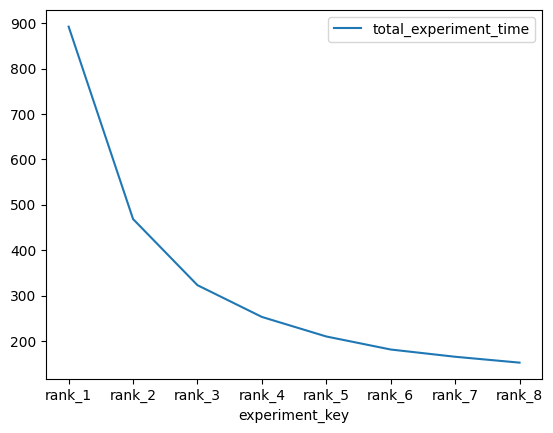

In [29]:
ax = df_total_experiment_time[['total_experiment_time']].plot()

In [30]:
exp_df.columns

Index(['experiment_key', 'training_loss', 'training_time',
       'train_forward_pass', 'train_backward_pass', 'train_optimizer_step',
       'train_post_processing', 'checkpointing', 'eval_validation_split_loss',
       'eval_validation_split_perplexity', 'eval_time', 'eval_post_processing',
       'eval_forward_pass', 'epoch_time', 'total_experiment_time'],
      dtype='object')

In [31]:
sum_keys_dict = {
    "experiment_key": ["experiment_key"],
    "checkpointing": ["checkpointing"],
    "steps": ['train_backward_pass', 'train_forward_pass', 'train_optimizer_step'],
    "steps+pp": ['train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'train_post_processing'],
    "steps+pp+eval": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'train_post_processing', 'eval_post_processing'],
    "steps+pp+eval+cp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'checkpointing'],
    "epochs": ['epoch_time'],
    "total": ["total_experiment_time"]
}

def create_sumfitted_df(df, key_dict):
        sumfitted_df = []
        for i in range(len(df)):
            rank_df = {}
            for col, sum_col in key_dict.items():
                if col == "experiment_key":
                    rank_df[col] = df.loc[i, col]
                else:
                    sum_val = 0.0
                    for col_s in sum_col: sum_val += df.loc[i, col_s]
                    rank_df[col] = sum_val
            sumfitted_df.append(rank_df)
        return pd.DataFrame(sumfitted_df)

df_durations = create_sumfitted_df(exp_df, sum_keys_dict)
df_durations

,experiment_key,checkpointing,steps,steps+pp,steps+pp+eval,steps+pp+eval+cp,epochs,total
0,rank_1,15.872082,753.408768,753.985181,760.214061,776.086144,887.460734,892.391252
1,rank_2,15.477232,380.802363,381.145202,384.801916,400.279148,456.047387,468.577937
2,rank_3,14.570776,254.973752,255.217620,257.807960,272.378736,309.064401,322.852776
3,rank_4,15.639479,191.723274,191.936171,194.306925,209.946404,238.264883,252.879303
4,rank_5,15.011904,153.946417,154.128923,156.389334,171.401237,193.400631,209.819150
5,rank_6,14.803817,128.470718,128.625686,130.895681,145.699498,164.111066,181.128093
6,rank_7,14.406718,111.630987,111.793442,114.347292,128.754010,144.320957,165.160337
7,rank_8,14.242796,99.160954,99.289893,101.857284,116.100081,129.817515,152.207979


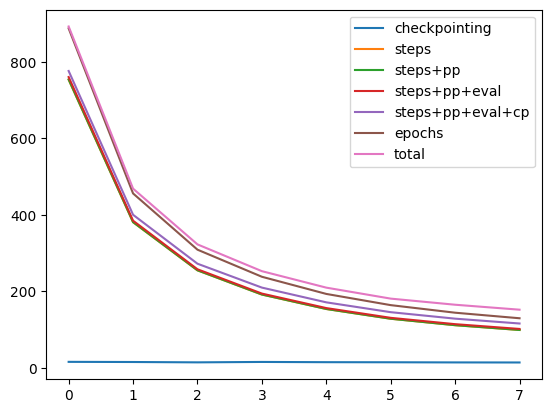

In [32]:
ax = df_durations.plot()

In [33]:
sum_keys_dict_2 = {
    "experiment_key": ["experiment_key"],
    "eval_forward_pass": ["eval_forward_pass"],
    "train_backward_pass": ["train_backward_pass"],
    "train_forward_pass": ["train_forward_pass"],
    "train_optimizer_step": ["train_optimizer_step"],
    "checkpointing": ["checkpointing"],
    "eval_post_processing": ["eval_post_processing"],
    "epochs": ['epoch_time'],
    "total": ["total_experiment_time"]
}

df_durations_2 = create_sumfitted_df(exp_df, sum_keys_dict_2)
df_durations_2

,experiment_key,eval_forward_pass,train_backward_pass,train_forward_pass,train_optimizer_step,checkpointing,eval_post_processing,epochs,total
0,rank_1,6.223922,523.606467,221.466365,8.335936,15.872082,0.004958,887.460734,892.391252
1,rank_2,3.627247,264.898681,111.494438,4.409244,15.477232,0.029468,456.047387,468.577937
2,rank_3,2.568096,176.654093,75.449722,2.869937,14.570776,0.022243,309.064401,322.852776
3,rank_4,2.318862,132.766991,56.725875,2.230408,15.639479,0.051892,238.264883,252.879303
4,rank_5,2.229751,105.457475,46.777424,1.711518,15.011904,0.030659,193.400631,209.819150
5,rank_6,2.210449,88.245866,38.811007,1.413845,14.803817,0.059546,164.111066,181.128093
6,rank_7,2.425814,76.505492,33.928029,1.197467,14.406718,0.128037,144.320957,165.160337
7,rank_8,2.484884,67.683892,30.506845,0.970217,14.242796,0.082508,129.817515,152.207979


/tmp/ipykernel_24019/1856178977.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(0, 9))


<Axes: xlabel='number of ranks'>

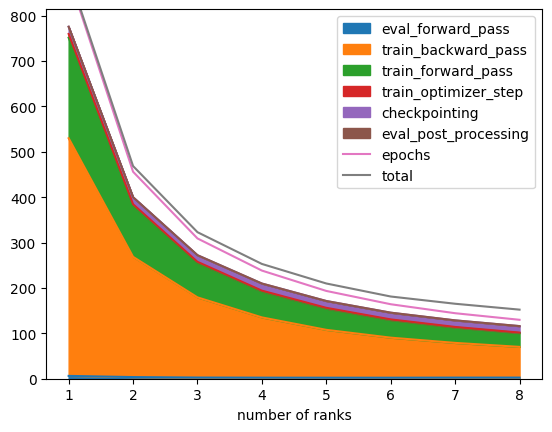

In [34]:
ax = df_durations_2[["eval_forward_pass", "train_backward_pass", "train_forward_pass", "train_optimizer_step", "checkpointing", "eval_post_processing"]].plot.area()
ax.set_xlabel("number of ranks")
ax.set_xticklabels(np.arange(0, 9))
df_durations_2[["epochs", "total"]].plot(ax=ax)

In [45]:
exp_acc_df.columns

Index(['experiment_key', 'training_loss', 'training_time',
       'train_forward_pass', 'train_backward_pass', 'train_optimizer_step',
       'train_post_processing', 'checkpointing', 'eval_validation_split_loss',
       'eval_validation_split_perplexity', 'eval_time', 'eval_post_processing',
       'eval_forward_pass', 'epoch_time', 'total_experiment_time',
       'eval_aggregate_and_calc'],
      dtype='object')

In [48]:
sum_keys_dict_2 = {
    "experiment_key": ["experiment_key"],
    "eval_forward_pass": ["eval_forward_pass"],
    "train_backward_pass": ["train_backward_pass"],
    "train_forward_pass": ["train_forward_pass"],
    "train_optimizer_step": ["train_optimizer_step"],
    "checkpointing": ["checkpointing"],
    "eval_aggregate_and_calc": ["eval_aggregate_and_calc"],
    "eval_post_processing": ["eval_post_processing"],
    "epochs": ['epoch_time'],
    "total": ["total_experiment_time"]
}
# Accelerator graph
df_durations_3 = create_sumfitted_df(exp_acc_df, sum_keys_dict_2)
df_durations_3

,experiment_key,eval_forward_pass,train_backward_pass,train_forward_pass,train_optimizer_step,checkpointing,eval_aggregate_and_calc,eval_post_processing,epochs,total
0,rank_1,6.223922,523.606467,221.466365,8.335936,15.872082,0.000000,0.004958,887.460734,892.391252
1,rank_2,3.580079,264.938759,111.812131,4.555703,15.563890,0.005256,0.106494,460.092969,466.843565
2,rank_3,2.517149,176.669452,74.451925,2.995433,18.547027,0.006561,0.128433,316.167121,323.282530
3,rank_4,2.300003,132.852093,56.468593,2.148134,18.184252,0.003603,0.154276,247.094822,254.764944
4,rank_5,2.191865,105.415398,46.037326,1.671096,15.459137,0.003615,0.103954,196.921385,204.949418
5,rank_6,2.077343,88.185516,38.460881,1.418775,15.971709,0.002977,0.159401,167.042277,175.729252
6,rank_7,2.425262,76.350899,33.404057,1.236781,15.501724,0.004060,0.133791,147.305725,157.102348
7,rank_8,2.445948,67.650715,29.934424,1.064773,14.245558,0.003084,0.193762,131.426717,141.397197


/tmp/ipykernel_24019/186886659.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(0, 9))


<Axes: xlabel='number of ranks'>

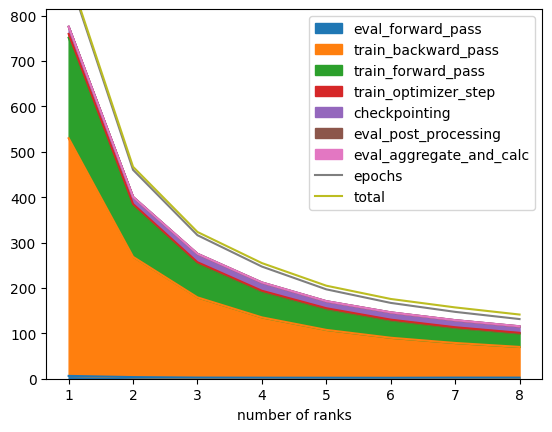

In [49]:
ax = df_durations_3[["eval_forward_pass", "train_backward_pass", "train_forward_pass", "train_optimizer_step", "checkpointing", "eval_post_processing", "eval_aggregate_and_calc"]].plot.area()
ax.set_xlabel("number of ranks")
ax.set_xticklabels(np.arange(0, 9))
df_durations_3[["epochs", "total"]].plot(ax=ax)